In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import re
import sys
from tqdm import tqdm
from tensorflow import keras
from sklearn.neighbors import NearestNeighbors
from keras.utils.vis_utils import plot_model

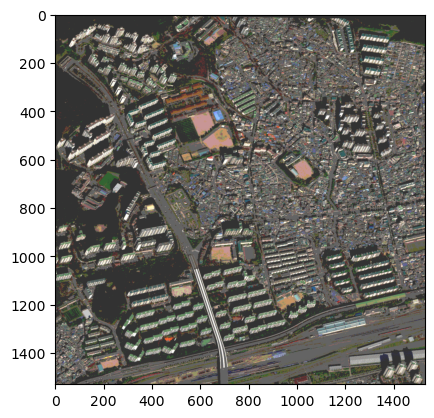

In [2]:

#import pictures and cut into slices
input_path = "../cse-seminar/inputs/tifBusan.tif"
img = cv2.imread(input_path)
img = cv2.convertScaleAbs(img, alpha = 50,beta = 50)
img = cv2.resize(img,(1530,1530))
plt.imshow(img)


# dimensions of the original image
height, width, _ = img.shape

# Define dimensions for each smaller image
small_width = width // 10
small_height = height // 10

# Slice the original image into smaller images
small_images = []
for row in range(10):
    for col in range(10):
        # starting and ending points of each small image
        start_x = col * small_width
        end_x = (col + 1) * small_width
        start_y = row * small_height
        end_y = (row + 1) * small_height

        # Extract from the original image
        small_image = img[start_y:end_y, start_x:end_x]

        # Append small image to list
        small_images.append(small_image)

# save smaller images
output_path = "../cse-seminar/small_images/"
for i, small_image in enumerate(small_images):
    cv2.imwrite( '../cse-seminar/small_images/small_image%d.png' % i, small_image)


In [3]:
# load small images
image_path = []
for root, dirs, files in os.walk('../cse-seminar/small_images_withlabel'):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)

images = []
testimg = []

for path in image_path:
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    testimg.append(img)

100%|██████████| 68/68 [00:00<00:00, 1445.61it/s]


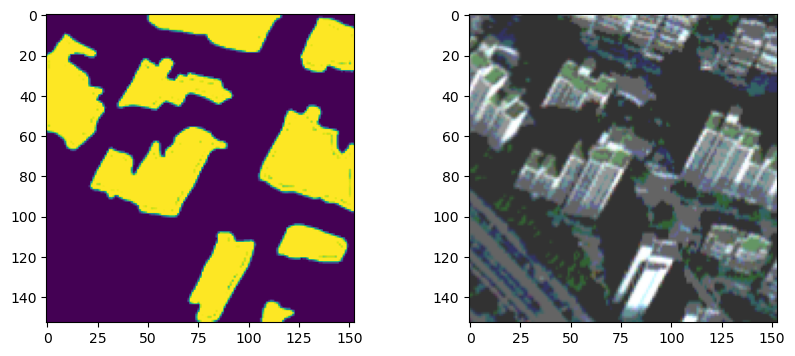

In [4]:
# a list to collect paths masks
mask_path = []
for root, dirs, files in os.walk('../cse-seminar/labeled_data'):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)

# create a list to store masks
testmasks = []
# iterate over mask paths
for path in tqdm(mask_path):
    # read the file
    mask = np.load(path)
    # add channel
    mask = mask[..., tf.newaxis]
    # append mask to the list
    testmasks.append(mask)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(testmasks[9].reshape(153,153))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
testmasks
#print(testmasks[9].reshape(153,153).shape)
ax1.imshow(testmasks[9])
ax2.imshow(testimg[9])

In [5]:
# Split data into train and test
def normalize_image(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image/ 255.0
    input_image = tf.image.resize(input_image, (128,128))
    return input_image

def normalize_mask(input_mask):
    input_mask = input_mask/ 255.0
    input_mask = tf.image.resize(input_mask, (128,128))
    input_mask = tf.cast(input_mask, tf.uint8)
    return input_mask

testimg = [normalize_image(i) for i in testimg]
testmasks =  [normalize_mask(m) for m in testmasks]

X_train, X_test, y_train, y_test = train_test_split(testimg, testmasks, test_size=0.2, random_state=42)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)

y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

X_train.element_spec, y_train.element_spec, X_test.element_spec, y_test.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [6]:
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask

# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [7]:
# zip images and masks
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_test, y_test))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [8]:
BATCH = 5
AT = tf.data.AUTOTUNE
BUFFER = 100

STEPS_PER_EPOCH = 54 //BATCH
VALIDATION_STEPS = 14 //BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [9]:
# Use pre-trained DenseNet121 without head
base = keras.applications.DenseNet121(input_shape=[128,128,3],
                                      include_top=False,
                                      weights='imagenet',
                                      )

In [10]:
len(base.layers)

427

In [11]:
#final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [12]:
#output of these layers
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [13]:
#Building the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

In [14]:
!pip install -q git+https://github.com/tensorflow/examples.git --quiet

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix
# Four upstack layers for upsampling sizes
# 4->8, 8->16, 16->32, 32->64
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [16]:
upstack[1].layers

In [17]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])

# downsample
down = downstack(inputs)
out = down[-1]

# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8

# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])

# define the final transpose conv layer
# image 128 by 128 with 2 classes
out = keras.layers.Conv2DTranspose(2, 3,
                                  strides=2,
                                  padding='same',
                                  )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

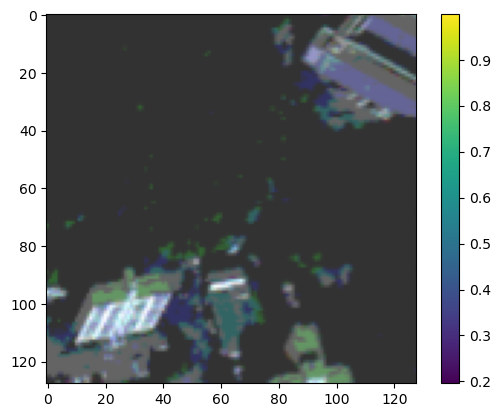

In [18]:
#checking for model and data compatibility
# infer on train dataset
example = next(iter(train))
preds = unet(example[0])
# visualize an image
plt.imshow(example[0][0])
plt.colorbar()
plt.show()

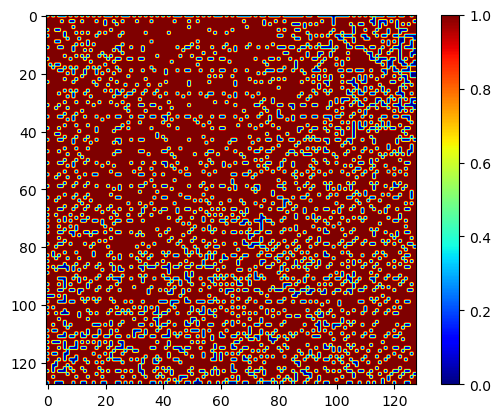

In [19]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0], cmap='jet')
plt.colorbar()

In [20]:
# test IoU Calculation from Kaggle
def calculate_iou(y_true, y_pred):


    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).

    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.

    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)

    """


    results = []

    for i in range(0,y_true.shape[0]):

        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br])

        # Calculate the area of boxInt, i.e. the area of the intersection
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.


        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)

        # append the result to a list at the end of each loop
        results.append(iou)

    # return the mean IoU score for the batch
    return np.mean(results)

In [21]:
import keras.backend as K

# Alex sein Schmutz
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou_score = tf.divide(intersection, union)
    return iou_score

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def KaggleIoU(y_true, y_pred):

    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours
    # trying to debug and almost give up.

    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

def testIoU(y_true, y_pred):
    # one hot encoding of predictions
    num_classes = y_pred.shape[-1]
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)

    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes)
    union = np.sum(np.logical_or(y_pred, y_true), axis=axes)

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)

    iou = np.mean(iou)
    return iou

def dice_coef(y_true, y_pred, smooth=0):
    class_num = 2
    for i in range(class_num):
        print(i)
        print(y_true)
        print(y_pred)
        y_true_f = K.flatten(y_true[:,:,:,0])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        print(y_true_f)
        print(y_pred_f)
        intersection = K.sum(y_true_f * y_pred_f)
        test = tf.reduce_min(intersection)
        print(test)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_medial(y_true, y_pred,epsilon=np.finfo(float).eps):
    y_true_f = K.flatten(y_true[:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

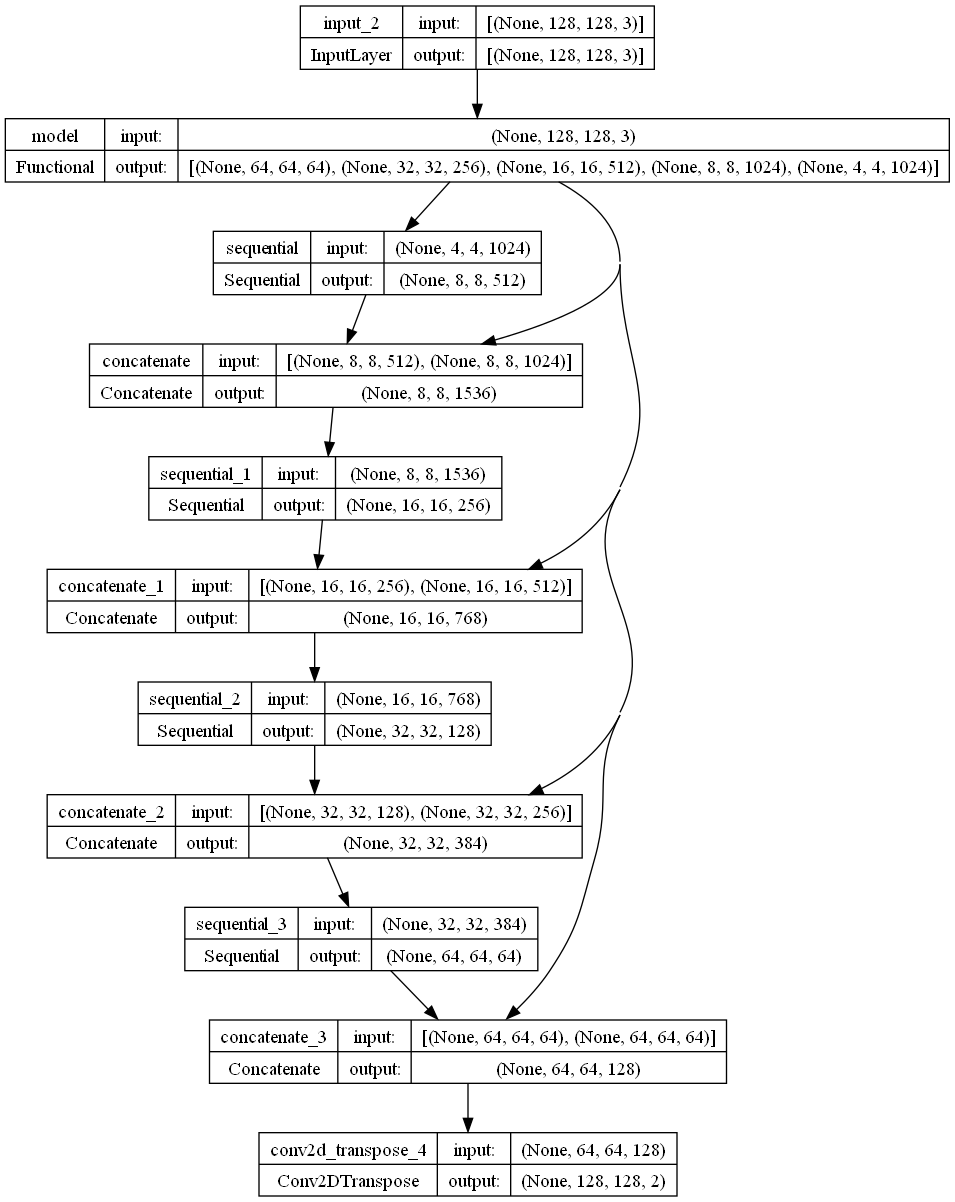

In [22]:
from keras.utils.vis_utils import plot_model
# compiling the model
def Compile_Model():
    unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                metrics=[iou_coef]
                #metrics=[tf.keras.metrics.IoU(num_classes=2)]
                 )

Compile_Model()
tf.keras.utils.plot_model(unet, show_shapes=True)

In [95]:
#training and fine-tuning
downstack.trainable = True
# compile again
Compile_Model()
hist_1 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=20,
               verbose=2)

Epoch 1/20
10/10 - 64s - loss: 0.0728 - iou_coef: 20.6911 - val_loss: 0.1410 - val_iou_coef: 6.7111 - 64s/epoch - 6s/step
Epoch 2/20
10/10 - 34s - loss: 0.0789 - iou_coef: -1.5941e+00 - val_loss: 0.2336 - val_iou_coef: -4.2482e+00 - 34s/epoch - 3s/step
Epoch 3/20
10/10 - 34s - loss: 0.0863 - iou_coef: -1.7363e+00 - val_loss: 0.2229 - val_iou_coef: -7.9326e-01 - 34s/epoch - 3s/step
Epoch 4/20
10/10 - 34s - loss: 0.0971 - iou_coef: -1.3860e+00 - val_loss: 0.2331 - val_iou_coef: 0.5872 - 34s/epoch - 3s/step
Epoch 5/20


KeyboardInterrupt: 

1/1 [==============================] - 4s 4s/step


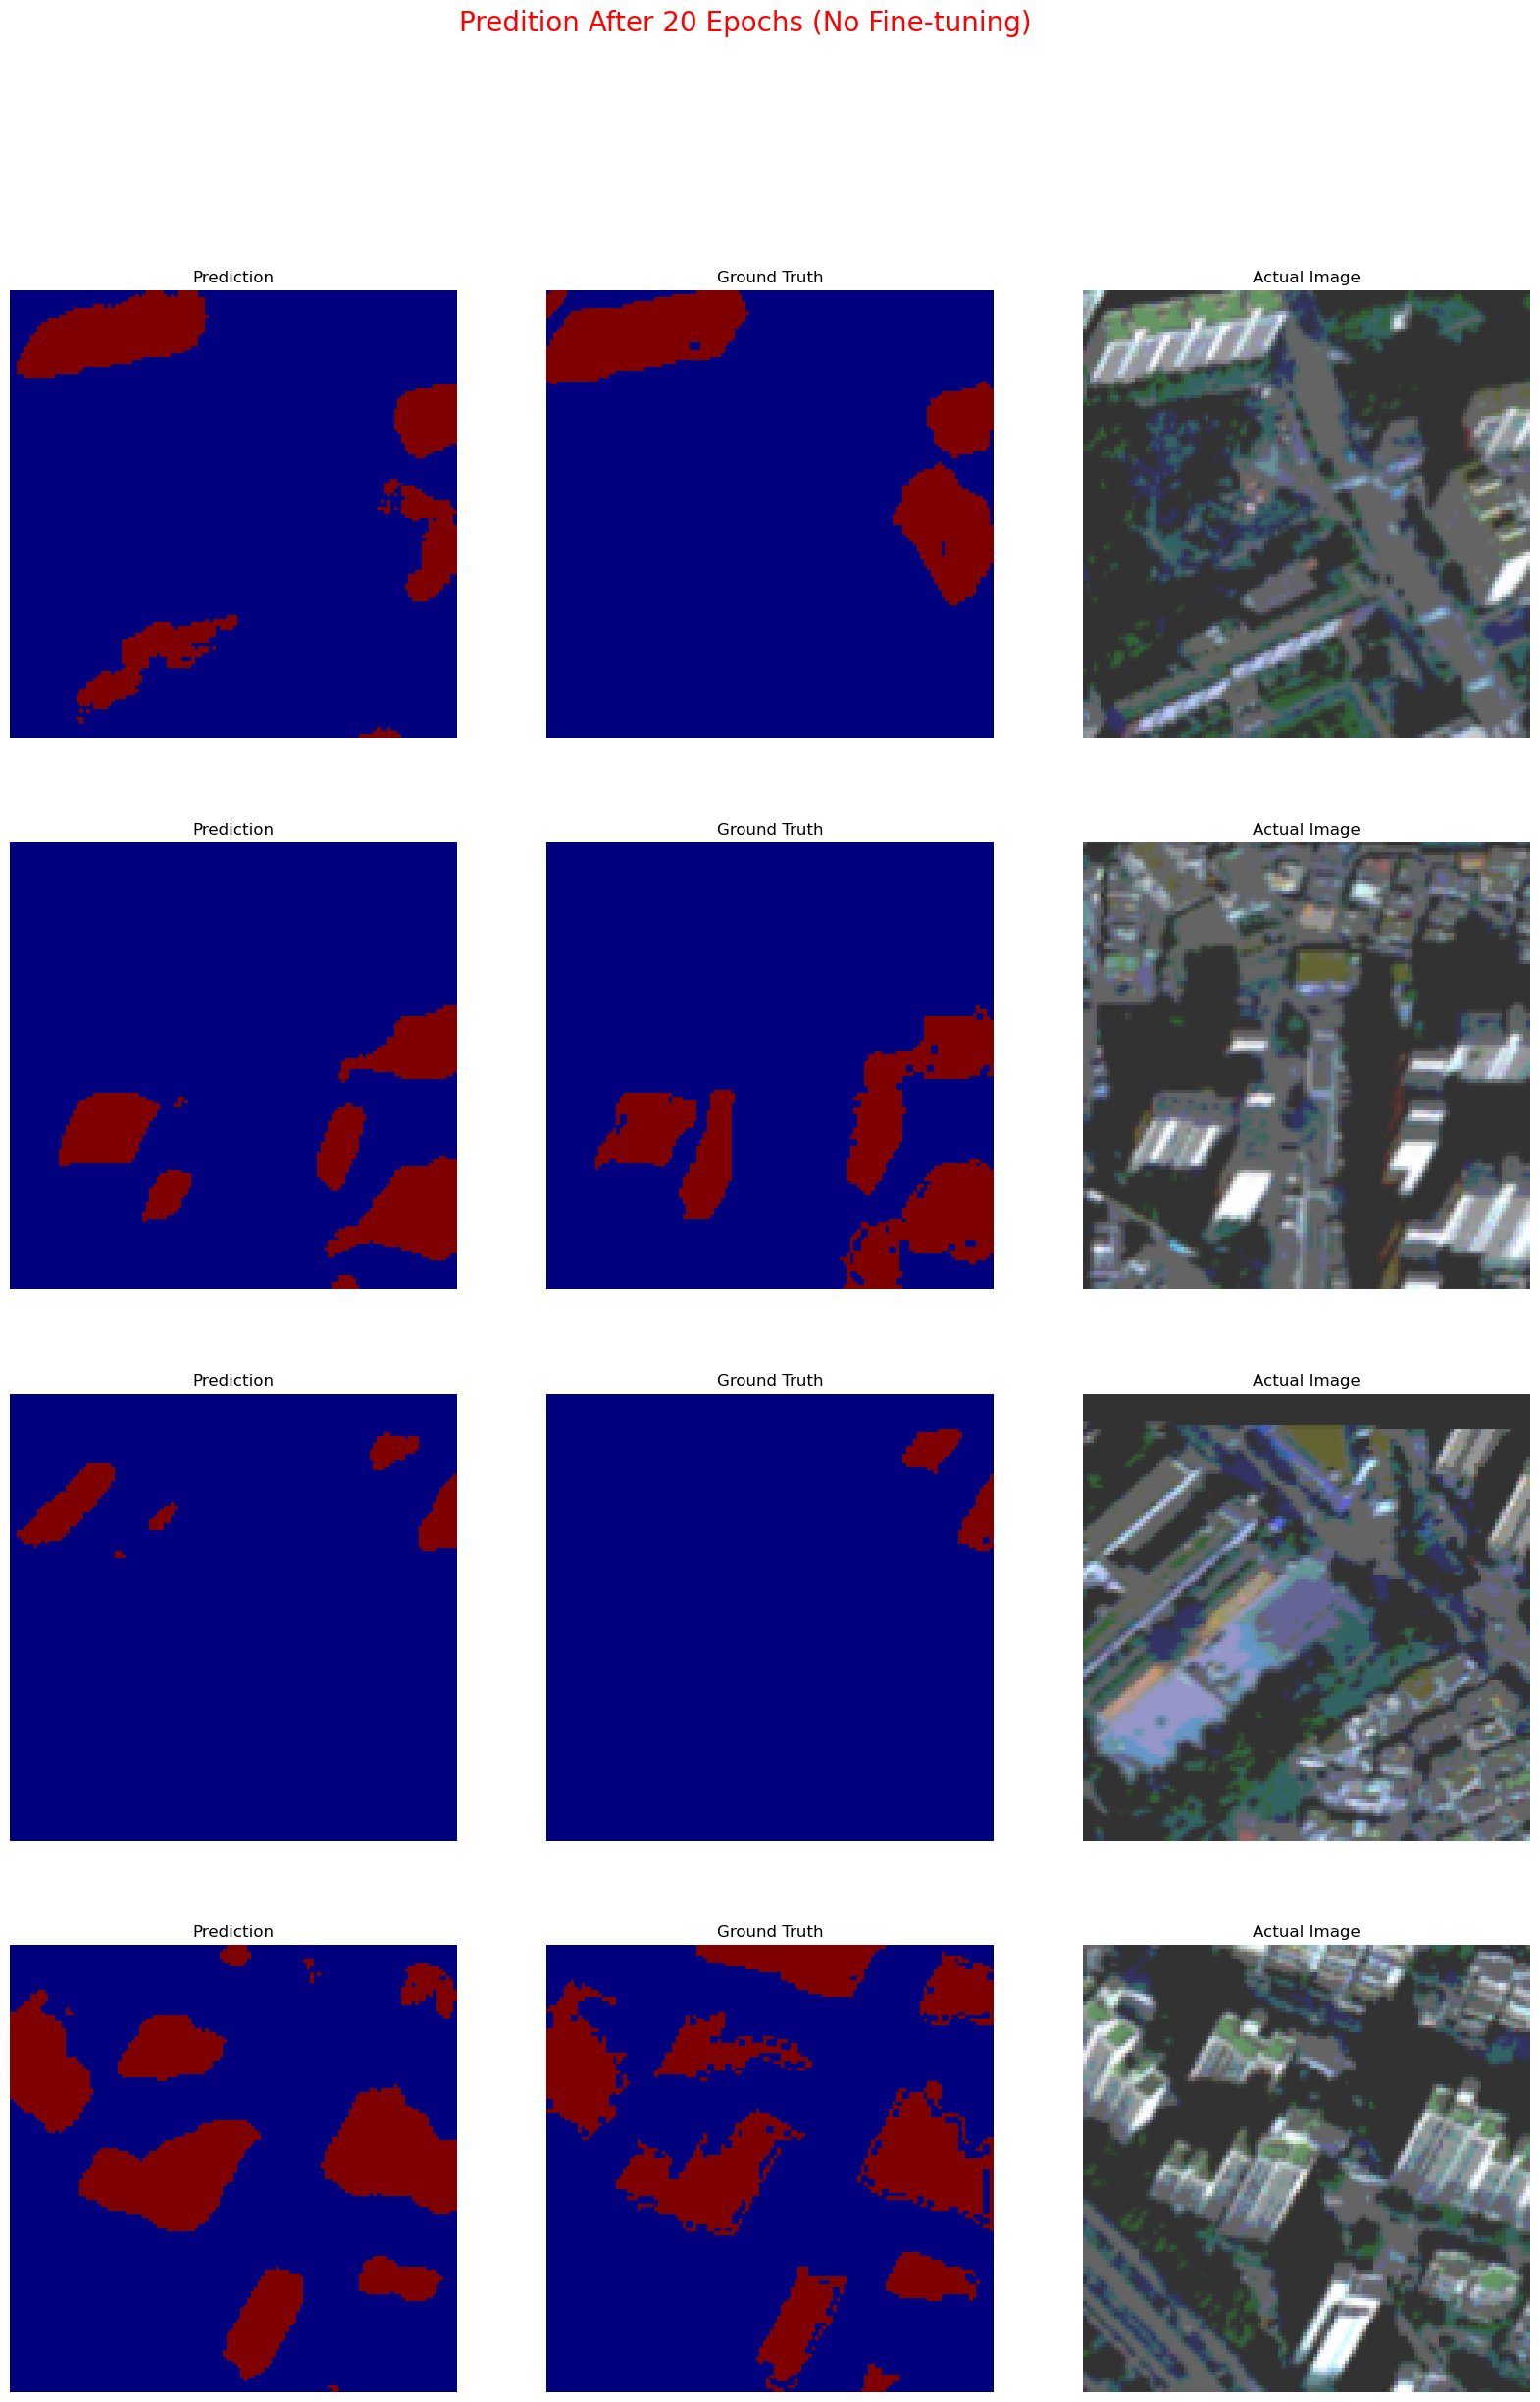

In [91]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 20 Epochs (No Fine-tuning)', color='red', size=20)
plt.show()

downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 20 to 40
hist_2 = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=50, initial_epoch = 20,
               verbose = 2
                 )

# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = unet.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 150 Epochs (By Fine-tuning from 51th Epoch)', color='red', size=20)
plt.show()

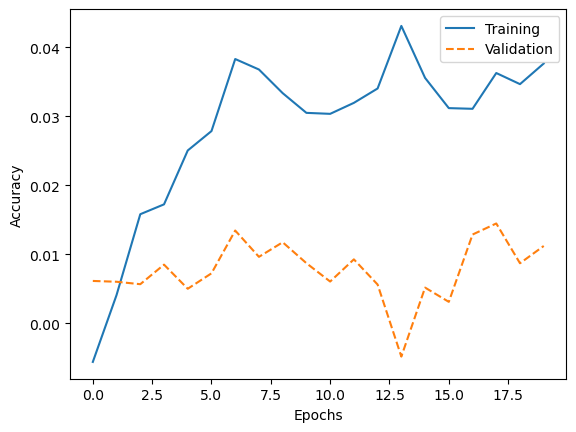

In [49]:
history_1 = hist_1.history
acc=history_1['iou']
val_acc = history_1['val_iou']

#history_2 = hist_2.history
#acc.extend(history_2['iou'])
#val_acc.extend(history_2['val_iou'])

plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim([0.7,1.0])
plt.legend()
plt.show()